Plane Image Classification

# Setup
Firstly, we load all the necessary packages used in this notebook and define some settings for visualizing the input image data. If you encounter `ModuleNotFoundError`, please install the corresponding package using `pip install` or `conda install`.

In [1]:
# Copyright 2021 ETH Zurich and University of Bologna.
# Licensed under the Apache License, Version 2.0, see https://www.apache.org/licenses/LICENSE-2.0 for details.
# SPDX-License-Identifier: Apache-2.0

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
import os
import logging
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import pathlib
import csv

from datetime import datetime

# set global seeds for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

# Setting parameters for plotting
plt.rcParams['figure.figsize'] = (15.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

logging.getLogger("tensorflow").setLevel(logging.DEBUG)

print("TensorFlow version: ", tf.__version__)


BASE_PATH = "/share/public/workspace/planes/data/"

2023-12-08 00:48:34.207928: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-08 00:48:34.241887: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 00:48:34.700473: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow version:  2.13.0


In [ ]:
# check if GPU is available
print("GPU is", "AVAILABLE" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is AVAILABLE


# Task 1

### Download the dataset
For this we use the keras.datasets.mnist package. This package contains the Fashion-MNIST dataset which is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. This dataset can be used as a drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

In [23]:
#Make label CSV out of file names



with open(BASE_PATH + 'plane_labels.csv', 'w', newline='') as file:
    writer = csv.writer(file)
   
    
    file_names = os.listdir(BASE_PATH + "planesnet")
    file_names = [BASE_PATH + "planesnet" + s for s in file_names]

    data_labels =  [s.split("/")[-1][0] for s in file_names]
    
    data = list(zip(file_names, data_labels))
    
    writer.writerow(["filename", "label"])
    writer.writerows(data)



In [24]:
with open(BASE_PATH + 'ship_labels.csv', 'w', newline='') as file:
    writer = csv.writer(file)
   
    
    file_names = os.listdir(BASE_PATH + "shipsnet")
    file_names = [BASE_PATH + "shipsnet" + s for s in file_names]

    data_labels =  [s.split("/")[-1][0] for s in file_names]
    
    data = list(zip(file_names, data_labels))
    
    writer.writerow(["filename", "label"])
    writer.writerows(data)


In [26]:
with open(BASE_PATH + 'combined_labels.csv', 'w', newline='') as file:
    writer = csv.writer(file)
   
    
    planes = os.listdir(BASE_PATH + "planesnet")
    ships = os.listdir(BASE_PATH + "shipsnet")

    planes = [BASE_PATH + "planesnet/" + s for s in planes]
    ships = [BASE_PATH + "shipsnet/" + s for s in ships]

    planes_label =  [int(s.split("/")[-1][0]) for s in planes]
    ships_label =  [int(s.split("/")[-1][0]) for s in ships]
    
    planes = list(zip(planes, planes_label, [0 for s in planes], np.logical_not(planes_label).astype(int)))
    ships = list(zip(ships, [0 for s in ships], ships_label, np.logical_not(ships_label).astype(int)))

    data = planes + ships

    writer.writerow(["filename", "plane", "ship", "none"])
    writer.writerows(data)

In [40]:
#KAI:
#BASE_PATH = "/share/kai/pizza_data/"
#ALE:
# BASE_PATH = "/share/public/workspace/planes/data"

""" data_labels = os.listdir(BASE_PATH)
data_labels =  [s[0] for s in data_labels]
print(data_labels[:50]) """
data_labels = pd.read_csv(BASE_PATH  + "combined_labels.csv")

data_labels['label'] = data_labels[['ship', 'plane', 'none']].idxmax(axis=1)
#data_labels['label'] = data_labels['label'].map({'plane': 0, 'ship': 1, 'none': 2})

train_df, tmpf_df = train_test_split(data_labels, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(tmpf_df, test_size=0.5, random_state=42)

print("Train: ")
display(train_df.head(5))

print("Validate: ")
display(val_df.head(5))

print("Sample: ")
display(test_df.head(5))


Train: 


,filename,plane,ship,none,label
2848,/share/public/workspace/planes/data/planesnet/...,0,0,1,none
19402,/share/public/workspace/planes/data/planesnet/...,0,0,1,none
13192,/share/public/workspace/planes/data/planesnet/...,0,0,1,none
12680,/share/public/workspace/planes/data/planesnet/...,0,0,1,none
12540,/share/public/workspace/planes/data/planesnet/...,0,0,1,none


Validate: 


,filename,plane,ship,none,label
2772,/share/public/workspace/planes/data/planesnet/...,0,0,1,none
12986,/share/public/workspace/planes/data/planesnet/...,0,0,1,none
22732,/share/public/workspace/planes/data/planesnet/...,0,0,1,none
17688,/share/public/workspace/planes/data/planesnet/...,1,0,0,plane
31678,/share/public/workspace/planes/data/planesnet/...,0,0,1,none


Sample: 


,filename,plane,ship,none,label
1303,/share/public/workspace/planes/data/planesnet/...,0,0,1,none
15322,/share/public/workspace/planes/data/planesnet/...,0,0,1,none
23667,/share/public/workspace/planes/data/planesnet/...,0,0,1,none
6832,/share/public/workspace/planes/data/planesnet/...,1,0,0,plane
8570,/share/public/workspace/planes/data/planesnet/...,0,0,1,none


In [41]:

datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.,
    rotation_range=360,
    zoom_range=0.3,
    horizontal_flip = True,
    vertical_flip = True,                                                           
)
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.,
    rotation_range=360,
    zoom_range=0.3,
    horizontal_flip = True,
    vertical_flip = True,
)
val_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.,
    rotation_range=360,
    zoom_range=0.3,
    horizontal_flip = True,
    vertical_flip = True,
)

image_size = 20
batch_size = 100

train_generator = datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = "filename",
    y_col = "label",
    class_mode = "categorical",
    batch_size = batch_size,
    seed = 42,
    shuffle = True,
    target_size=(image_size,image_size)
)

validate_generator = val_datagen.flow_from_dataframe(
    dataframe = val_df,
    x_col = "filename",
    y_col = "label",
    class_mode = "categorical",
    batch_size = batch_size,
    seed = 42,
    shuffle = False,
    target_size=(image_size,image_size)
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = "filename",
    y_col = "label",
    class_mode = "categorical",
    batch_size = batch_size,
    seed = 42,
    shuffle = False,
    target_size=(image_size,image_size)
)

Found 28800 validated image filenames belonging to 3 classes.
Found 3600 validated image filenames belonging to 3 classes.
Found 3600 validated image filenames belonging to 3 classes.


In [6]:


# # Load Fashion-Mnist dataset, we can use Tensorflow for this
# (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# # we save the pixels before normalization for plotting
# train_images_float = train_images.astype(np.float32)
# test_images_float = test_images.astype(np.float32)

# # Normalize the input image so that each pixel value is between 0 to 1.
# train_images = train_images.astype(np.float32) / 255.0
# test_images = test_images.astype(np.float32) / 255.0

# print("Shape of train dataset: {}".format(train_images.shape))
# print("Shape of train labels: {}".format(train_labels.shape))
# print("Shape of test dataset: {}".format(test_images.shape))
# print("Shape of test labels: {}".format(test_labels.shape))


### Visualize the data
We can visualize the data by plotting 5 samples of each class. We can see that the images are in grayscale format. 

In [ ]:
%matplotlib inline
for n in range(10):
    sample_batch, sample_labels = next(train_generator)

    sample_image = sample_batch[0]
    sample_image = sample_image * 255

    sample_image = sample_image.astype(int)

    plt.imshow(sample_image)
    plt.title(f"Labels: {sample_labels[0]}")
    plt.show()

### Create the Keras model
The input data is in the range of [0, 255]. We need to rescale the input data to the range of [0, 1] before feeding it to the model because the model should train on normalized and standardized data. We can do this by dividing the input data by 255. Thus, we ensure that all features are in the same range. We create a simple Keras model with one convolutional layers and a dense layer. The model is compiled with the Adam optimizer and the categorical cross-entropy loss function.

In [42]:
from tensorflow.keras import layers, models
from keras.layers import Conv2D, MaxPooling2D
from keras.initializers import glorot_normal, RandomNormal, Zeros
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization

model = models.Sequential()

model.add(BatchNormalization(input_shape = (20, 20, 3)))

model.add(Conv2D(filters = 32, kernel_size = 3, activation ='relu', input_shape = (20, 20, 3))) 
model.add(MaxPooling2D(pool_size = 2))


model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))

model.add(Flatten()) 

# fully connected layer
model.add(Dense(units = 64,activation = 'relu'))

# Classification layer
model.add(Dense(3, activation = 'softmax')) 




2023-12-08 01:17:27.956491: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 01:17:27.996117: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 01:17:27.996259: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [43]:
# Compile the model
opt = keras.optimizers.Adam(learning_rate=0.0001, weight_decay=1e-5)
model.compile(optimizer=opt,
                # the loss function is the sparse categorical cross-entropy
                # loss. It is used when there are two or more label classes.            
                # loss='binary_crossentropy',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [47]:
# View the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 20, 20, 3)         12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 18, 18, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 9, 9, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 64)          0         
 g2D)                                                            
                                                        

In [44]:
# Train the model (this will take a while)
# The early stopping (es) callback will stop the training when the validation loss stops improving
es = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history =  model.fit(
    train_generator,
    epochs=20,
    validation_data=validate_generator,
    # callbacks = [es]
)

Epoch 1/20


2023-12-08 01:17:42.078026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906
2023-12-08 01:17:42.668048: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-08 01:17:42.681668: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a58819b170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-08 01:17:42.681686: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2023-12-08 01:17:42.684519: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-08 01:17:42.744632: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

288/288 [==============================] - 8s 23ms/step - loss: 0.4455 - accuracy: 0.8388 - val_loss: 0.3526 - val_accuracy: 0.8819
Epoch 2/20
288/288 [==============================] - 6s 21ms/step - loss: 0.2712 - accuracy: 0.8969 - val_loss: 0.2242 - val_accuracy: 0.9161
Epoch 3/20
288/288 [==============================] - 6s 21ms/step - loss: 0.2105 - accuracy: 0.9198 - val_loss: 0.1805 - val_accuracy: 0.9325
Epoch 4/20
288/288 [==============================] - 6s 21ms/step - loss: 0.1896 - accuracy: 0.9264 - val_loss: 0.1631 - val_accuracy: 0.9356
Epoch 5/20
288/288 [==============================] - 6s 22ms/step - loss: 0.1771 - accuracy: 0.9313 - val_loss: 0.1418 - val_accuracy: 0.9508
Epoch 6/20
288/288 [==============================] - 6s 21ms/step - loss: 0.1675 - accuracy: 0.9341 - val_loss: 0.1404 - val_accuracy: 0.9469
Epoch 7/20
288/288 [==============================] - 6s 22ms/step - loss: 0.1614 - accuracy: 0.9377 - val_loss: 0.1442 - val_accuracy: 0.9439
Epoch 8/20

In [48]:
# save the model so we can use it later
# without having to retrain it

dt = datetime.now().strftime("%Y%m%d_%H%M%S")

# check if 'model' directory exists
if not os.path.exists('models'):
    os.makedirs('models')

print(f"Saving to models/{dt}.keras")

model.save(f'models/{dt}.keras')
model.save(f'models/{dt}.h5')

Saving to models/20231208_012012.keras


/share/public/anaconda3/envs/ml/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [49]:
# Evaluate the model on the test set
from keras.models import load_model

# model = load_model('models/model1.h5')

fp_test_loss, fp_test_acc = model.evaluate(test_generator, verbose=2)
print('Test accuracy:', fp_test_acc)
print('Test loss:', fp_test_loss)

36/36 - 1s - loss: 0.1168 - accuracy: 0.9556 - 750ms/epoch - 21ms/step
Test accuracy: 0.9555555582046509
Test loss: 0.11678236722946167


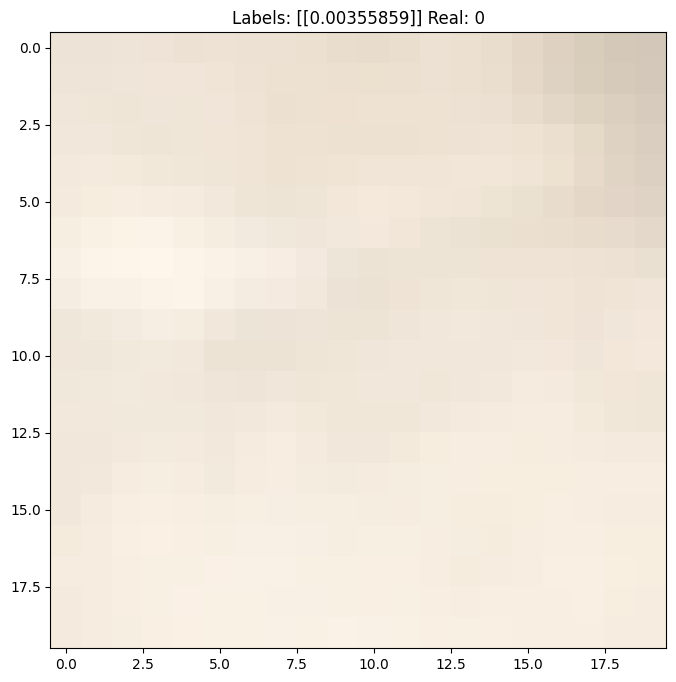

In [111]:


sample_batch, sample_labels = next(train_generator)

sample_image = sample_batch[0]
#sample_image = sample_image.astype(int)
output = model(sample_image.reshape(1, 20, 20, 3))

#

plt.imshow(sample_image)
plt.title(f"Labels: {output} Real: {sample_labels[0]}")
plt.show()

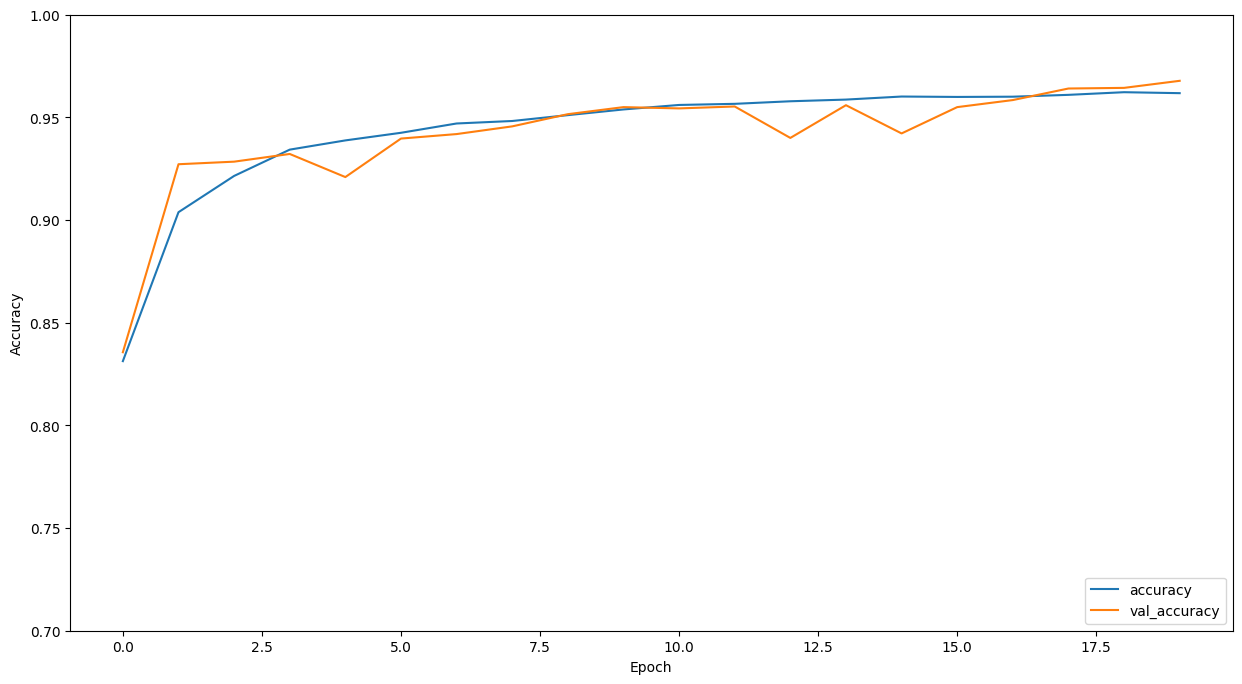

In [112]:
# Plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1])
plt.legend(loc='lower right')

# Evaluate the accuracy via a confusion matrix
We can evaluate the accuracy of the model by plotting a confusion matrix. The confusion matrix shows the ratio of correct and incorrect predictions for each class.

In [50]:
# plot the confusion matrix for the quantized model
from sklearn.metrics import confusion_matrix
import itertools

"""
function: plot_confusion_matrix
    - input: cm, classes, normalize, title, cmap
    - output: none
    - description: plots the confusion matrix
"""

def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

36/36 [==============================] - 1s 19ms/step
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 

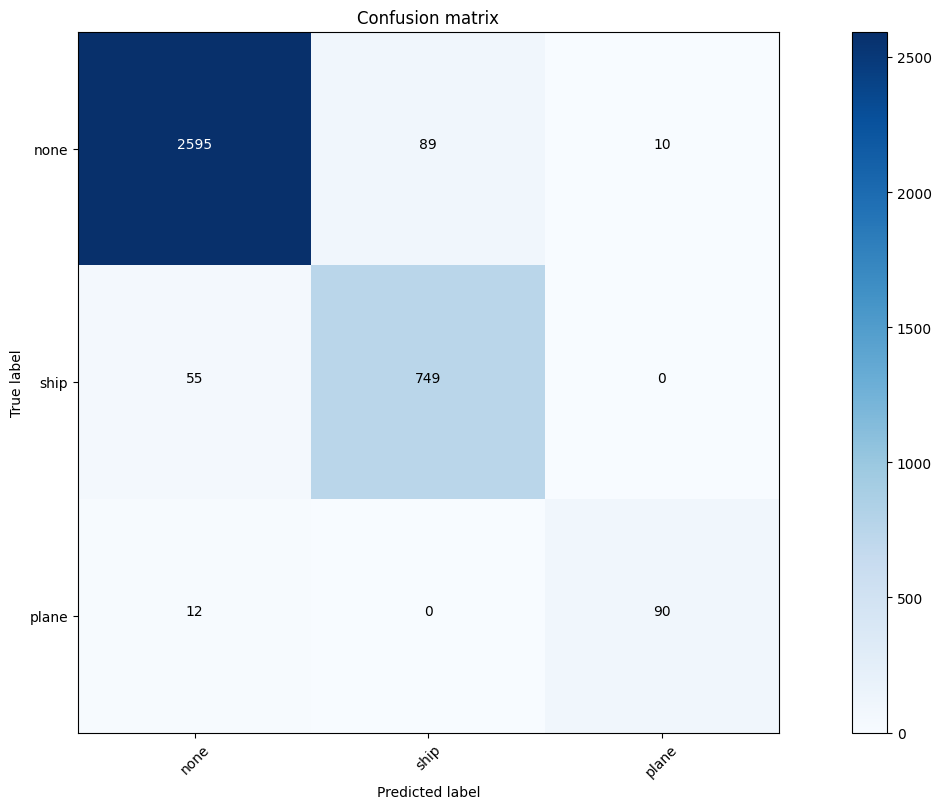

In [55]:

# classes = {"none", "plane", "ship"}

cm = confusion_matrix(test_generator.classes, np.argmax(model.predict(test_generator), axis=-1))
# plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

print(test_generator.classes)
print('Confusion Matrix')
print(cm)
plot_confusion_matrix(cm, {"ship", "plane", "none"})


In [56]:
correct = 0
incorrect = 0

amount = len(test_df) // 4

for i in range(0, amount):
    
    sample_batch, sample_labels = next(test_generator)
    sample_image = sample_batch[0]
    output = model(sample_image.reshape(1, 20, 20, 3))
    if output > 0.5:
        output = 1
    else: output = 0
    
    if output == sample_labels[0]:
        correct += 1
    else: incorrect += 1
    print("correct: ", correct, " ", "incorrect: ", incorrect, end = "\r")

print("\n")
print((correct/amount)*100, "%", "correct")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Sliding Window

In [80]:
import cv2
from keras.models import load_model

# BASE_PATH = "D:/Dokumente/ETH/ML/Plane_Image_Classification/"

# model = load_model('models/20231207_233127.h5')

# image = cv2.imread(BASE_PATH + 'scenes/planes/scene_1.png')
image = cv2.imread(BASE_PATH + 'scenes/frankenstein.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = image / 255 # scale

resize = 1

image = cv2.resize(image, dsize=(image.shape[1]//resize, image.shape[0]//resize))

plt.imshow(image)
plt.show()


window_size = (20, 20)  
stride = (10, 10)  


height, width, _ = image.shape

predictions = []
        
count = 0

# Slide the window over the image
for y in range(0, (height - window_size[0] + 1), stride[0]):
    for x in range(0, width - window_size[1] + 1, stride[1]):
        
        patch = image[y:y + window_size[0], x:x + window_size[1], :]
        
        # plt.imshow(patch)
        if window_size[0] != 20 or window_size[1] != 20:
            patch = cv2.resize(patch, (20, 20))

        patch = patch.reshape(1, 20, 20, 3)
        

        prediction = model(patch)
        count += 1        
        # plt.title(f"Labels: {prediction}")
        # plt.show()
        
        if prediction[0][1] > 0.5:  
            predictions.append(((x, y), (x + window_size[1], y + window_size[0]), "plane"))
        if prediction[0][2] > 0.5:  
            predictions.append(((x, y), (x + window_size[1], y + window_size[0]), "ship"))

print(f"{count} windows!")

error: OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - Can't parse 'dsize'. Sequence item with index 0 has a wrong type
>  - Can't parse 'dsize'. Sequence item with index 0 has a wrong type


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


((330, 10), (350, 30), 'plane')


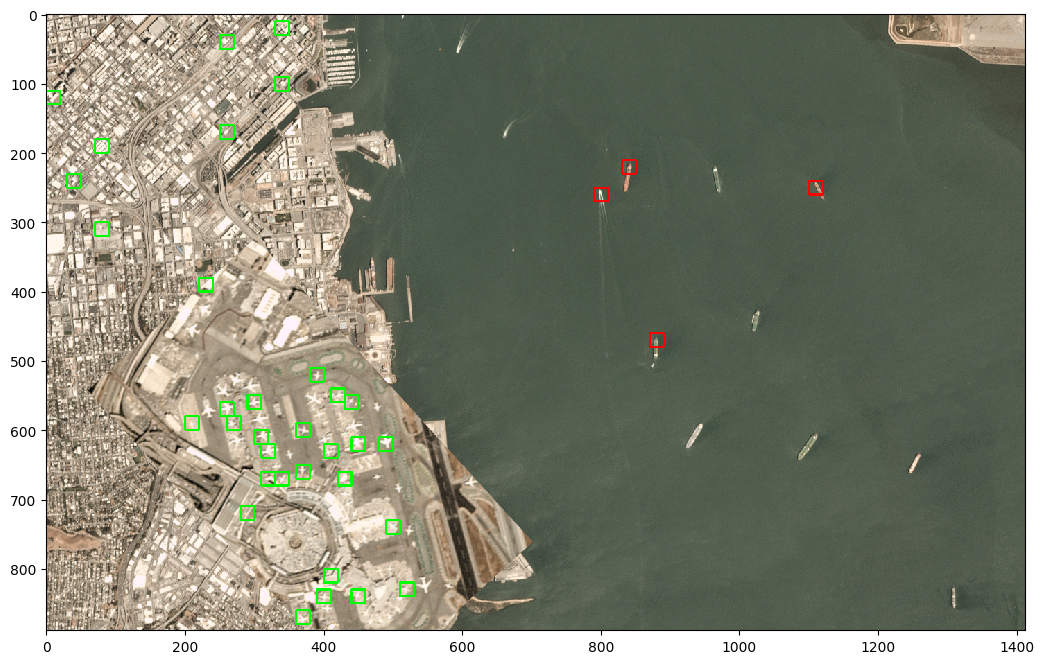

In [79]:
print(predictions[0])
for box in predictions:
    cv2.rectangle(image, box[0], box[1], (0, 255, 0) if box[2] == "plane" else (255, 0, 0), 2)

plt.imshow(image)
plt.show()


# Convert the keras model to a tflite model
We can convert the keras model to a tflite model by using the `tf.lite.TFLiteConverter.from_keras_model_file()` function. After converting the model, we can save it to a file. Furthermore, we compare the size of the keras model and the tflite model. The difference is due to the fact that we have a lot of metadata in the keras model which is not present in the tflite model, such as the model architecture, optimizer, loss function, etc. This is also why you cannot call the `model.summary()` function on the tflite model.

In [ ]:
# Convert the model to TFLite without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(fp_model)
fp_tflite_model = converter.convert()

# Save the model to disk
open("models/fmnist_model_f32.tflite", "wb").write(fp_tflite_model)

# Show the model size for the non-quantized HDF5 model
fp_h5_in_kb = os.path.getsize('models/fmnist_model_f32.h5') / 1024
print("HDF5 Model size without quantization: %d KB" % fp_h5_in_kb)

# Show the model size for the non-quantized TFLite model
fp_tflite_in_kb = os.path.getsize('models/fmnist_model_f32.tflite') / 1024
print("TFLite Model size without quantization: %d KB" % fp_tflite_in_kb)

# Determine the reduction in model size
print("\nReduction in file size by a factor of %f" % (fp_h5_in_kb / fp_tflite_in_kb))

# Task 2

### Quantize with dynamic range optimization
We convert the Keras model to an float32 tflite model with dynamic range optimization. Dynamic range quantization is a technique that uses the full range of the data type to represent the weights and activations. This is done by calculating the range of the weights and activations and then scaling them to the full range of the data type. This is done by using the `tf.lite.Optimize.DEFAULT` flag which enables quantization of all fixed parameters. However, this only quantizes static parameters such as weights and biases. The input and output tensors are not quantized. 

In [ ]:
# Convert the model to TFLite with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(fp_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
dynR_quant_tflite_model = converter.convert()

# Save the model to disk
open("models/fmnist_model_quant8_dynR.tflite", "wb").write(dynR_quant_tflite_model)


print("Model was saved at location: %s" % os.path.abspath('models/fmnist_model_quant8_dynR.tflite'))

In [ ]:
interpreter = tf.lite.Interpreter(model_content=dynR_quant_tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

### Quantize the model to 8-bit integer precision
We can also quantize the model to **full** 8-bit integer precision. This will reduce the model size and improve the inference speed. To quantize the variable data (such as model input/output and intermediates between layers), you need to provide a `RepresentativeDataset`. This is a generator function that provides a set of input data that's large enough to represent typical values. It allows the converter to estimate a dynamic range for all the variable data. (The dataset does not need to be unique compared to the training or evaluation dataset.) To support multiple inputs, each representative data point is a list and elements in the list are fed to the model according to their indices.

In [ ]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(fp_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int8 = converter.convert()

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant_int8)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

In [ ]:
# Save the quantized model to disk
open("models/fmnist_full_quant.tflite", "wb").write(tflite_model_quant_int8)

print("Model was saved at location: %s" % os.path.abspath('models/fmnist_full_quant.tflite'))

In [ ]:
# Show the model size for the 8-bit quantized TFLite model
tflite_quant_in_kb = os.path.getsize('models/fmnist_full_quant.tflite') / 1024
print("TFLite Model size with 8-bit quantization: %d KB" % tflite_quant_in_kb)

print("TFLite Model size without quantization: %d KB" % fp_tflite_in_kb)

# Determine the reduction in model size
print("\nReduction in model size by a factor of %f" % (fp_tflite_in_kb / tflite_quant_in_kb))

### Performance evaluation of TF Lite models
Before deploying the model to the MCU we would like to get an idea about how good it will perform on the actual hardware. For a first estimate we can do it in software. In order to evaluate the performance of our TF Lite models we have to define a few helper functions. The `run_tflite_model` function performs the inference on the TF Lite model. The inference is initiated by the `invoke` method of the interpreter. The `set_input_tensor` method sets the input tensor. The `get_output_tensor` method returns the output tensor. The `evaluate_model` function evaluates the performance of the model by running inference on the whole test dataset and returning the accuracy.

In [ ]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    if (test_image_index % 1000 == 0):
      print("Evaluated on %d images." % test_image_index)

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions


# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global test_images
  global test_labels

  test_image_indices = range(test_images.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

In [ ]:
# this might take a few minutes (~ 1- 2 minutes)
# if it takes longer than that, I suggest to 
# restart the runtime and try again
# if the issue still persists, restart your computer
tflite_model_quant_int8_file = pathlib.Path('models/fmnist_full_quant.tflite')
tflite_model_quant_int8_model_type = "Full Post-Quantized INT8"

evaluate_model(tflite_model_quant_int8_file, tflite_model_quant_int8_model_type)
print("Full-precision model accuracy is %.4f%% (Number of test samples=%d)" % (fp_test_acc * 100, len(test_images)))

In [ ]:
# we plot also the confusion matrix of the quantized model
tflite_model_quant_int8_pred = run_tflite_model(tflite_model_quant_int8_file, range(test_images.shape[0]))
cm = confusion_matrix(test_labels, tflite_model_quant_int8_pred);
plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization of the quantized model', cmap=plt.cm.Spectral.reversed())

In [ ]:
# compute the accuracy of the quantized model
from sklearn.metrics import accuracy_score
full_int8_accuracy = accuracy_score(test_labels, tflite_model_quant_int8_pred)
print("Full-precision model accuracy is %.4f%% (Number of test samples=%d)" % (fp_test_acc * 100, len(test_images)))
print("Quantized model accuracy is %.4f%% (Number of test samples=%d)" % (full_int8_accuracy * 100, len(test_images)))

### Writing the model to a C header file for use on the MCU
We need to store the model parameters in a C header file so that we can run inference on the microcontroller with new input data (i.e.) from the testset. 

In [ ]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

    c_str = ''

    # Create header guard
    c_str += '#ifndef ' + var_name.upper() + '_H\n'
    c_str += '#define ' + var_name.upper() + '_H\n\n'

    # Add array length at top of file
    c_str += '\nstatic const unsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

    # Declare C variable
    c_str += 'static const unsigned char ' + var_name + '[] = {'
    hex_array = []
    for i, val in enumerate(hex_data) :

        # Construct string from hex
        hex_str = format(val, '#04x')

        # Add formatting so each line stays within 80 characters
        if (i + 1) < len(hex_data):
            hex_str += ','
        if (i + 1) % 12 == 0:
            hex_str += '\n '
        hex_array.append(hex_str)

    # Add closing brace
    c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

    # Close out header guard
    c_str += '#endif //' + var_name.upper() + '_H'

    return c_str

In [ ]:
c_model_name = 'q8fmnist'
# check if dir 'cfiles' exists, if not create it
if not os.path.exists('cfiles'):
    os.makedirs('cfiles')
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model_quant_int8, c_model_name))

### Saving test data used for inference on the MCU
Additionally, we will save some samples from the test set which we will send via UART to the microcontroller. The microcontroller will then perform inference on these samples and send the results back to the host computer via a Python script that we prepared for you. 

In [ ]:
# save the test data as numpy arrays
np.save('x_test_fmnist.npy', test_images_float.astype(np.uint8))
np.save('y_test_fmnist.npy', test_labels.astype(np.uint8))
# plot the first 5 images in the test set with their labels
# map class labels to names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(test_images_float.astype(np.uint8)[i], cmap='gray')
    plt.title('Label: %s' % class_names[test_labels[i]])

# print the location of the files
print('Test image data location: ', os.path.abspath('x_test_fmnist.npy'))
print('Test labels location: ', os.path.abspath('y_test_fmnist.npy'))

# Task 3

### Quantization-aware training
In this exercise, the dataset and model are very simple and the accuracy drop in more advanced applications might drop tremendously. A way to mitigate this is to train the model with quantization in mind. This is called quantization-aware training. In this exercise, we will train a model with quantization-aware training and then convert it to a TF Lite model. In order to generate a QAT model, we can use TF's `tfmot.quantization.keras.quantize_model` API. Afterward, we proceed in the same manner as before.

In [ ]:
!pip install -q tensorflow-model-optimization

In [ ]:
import tensorflow_model_optimization as tfmot

# Convert the model to a quantization aware model
quant_aware_model = tfmot.quantization.keras.quantize_model(fp_model)

# `quantize_model` requires a recompile.
quant_aware_model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

quant_aware_model.summary()

In [ ]:
# Train and evaluate the quantization aware model
quant_aware_model.fit(
                  train_images,
                  train_labels,
                  epochs=10,
                  validation_data=(test_images, test_labels),
                  callbacks=[es]
              )

We see that the accuracy of the QAT model is higher than the accuracy of the model that was quantized after training. The effect of quantization-aware training is more pronounced in more complex models.

In [ ]:
# evaluate the model on the test set
quant_loss, quant_acc = quant_aware_model.evaluate(test_images, test_labels, verbose=0)
print('Quantization aware training loss: ', quant_loss)
print('Quantization aware training accuracy: ', quant_acc)
print('Full-precision training accuracy: ', fp_test_acc)

In [ ]:
# convert the QAT model to a fully quantized model using TFLite

def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int8_qat = converter.convert()

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant_int8_qat)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)
# Save the quantized model to disk
open("models/fmnist_qat_int8.tflite", "wb").write(tflite_model_quant_int8_qat)

In [ ]:
c_model_name = 'qat8fmnist'
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model_quant_int8_qat, c_model_name))

In [ ]:
# this might take a few minutes (~ 1- 2 minutes)
# if it takes longer than that, I suggest to 
# restart the runtime and try again
# if the issue still persists, restart your computer
tflite_model_quant_int8_qat_file = pathlib.Path('models/fmnist_qat_int8.tflite')
tflite_model_quant_int8_qat_type = "Full QAT INT8"

evaluate_model(tflite_model_quant_int8_qat_file, tflite_model_quant_int8_qat_type)
print("Full-precision model accuracy is %.4f%% (Number of test samples=%d)" % (fp_test_acc * 100, len(test_images)))

In [ ]:
# evaluate the model on the test set
tflite_model_quant_int8_qat_file = "models/fmnist_qat_int8.tflite"
tflite_model_quant_int8_qat_model_type = "Quantized aware training model"
tflite_model_quant_int8_qat_pred = run_tflite_model(tflite_model_quant_int8_qat_file, range(test_images.shape[0]))
cm = confusion_matrix(test_labels, tflite_model_quant_int8_qat_pred);
plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization of the quantized model', cmap=plt.cm.Spectral.reversed())


In [ ]:
# compute the accuracy of the model
full_qat_int8_accuracy = accuracy_score(test_labels, tflite_model_quant_int8_qat_pred)
print('Full QAT INT8 accuracy is %.4f%% (Number of test samples=%d)' % (full_qat_int8_accuracy * 100, len(test_images)))
print('Full-precision model accuracy is %.4f%% (Number of test samples=%d)' % (fp_test_acc * 100, len(test_images)))

# Task 4

  ### Quantization-aware training with pruning
  In order to further optimize the model, we can combine quantization-aware training with pruning. Pruning denotes the removal of static parameters. It helps to mitigate negative side effects of machine learning models such as overfitting, model complexity, and model size. For pruning, we can define a schedule, but also the type of pruning, i.e. structured or unstructured. In TensorFlow, we can use the `tfmot.sparsity.keras.prune_low_magnitude` API to prune a model.  <br/>
  
  * **Structured pruning** Involves removing entire groups of parameters from the model, i.e. weights are systematically zeroed out at the beginning of the training process. For example, in a CNN, we might remove entire filters from a layer, which would remove all the weights associated with that filter. The shape of the model is preserved. <br/>
  
  * **Unstructured pruning** Here, we are removing individual parameters from the model, without any regard for their position in the model. We try to find and remove the less salient connection in the model wherever they are. For example, we might simply remove the smallest weights from the model, regardless of where they are located. The shape of the model is not preserved. This type of pruning is sometimes referred to as _channel pruning_. By default, unstructured pruning is used except if the `block_size` parameter is specified in the `pruning_params` of the `PruneLowMagnitude` class. <br/>

  The schedule can be either constant or dynamic. <br/>
  * **Constant pruning schedule** The pruning rate is constant throughout the training process. This means we eliminate the same number of parameters at each step. <br/>
  
  * **Dynamic pruning schedule** The pruning rate might change during training, i.e. the sparsity changes. <br/>

### 1. Structured pruning with constant sparsity

In [ ]:
# Strucutred pruning with constant sparsity
pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=2000, frequency=100),
        'block_size': (1, 1),
}

# Create a pruning model
pruned_model = tfmot.sparsity.keras.prune_low_magnitude(fp_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
pruned_model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

pruned_model.summary()

<color style="color:red"> **Important:** </color> If you get an error like `train_function -> train_function`, simply run the cell again. Furthermore, you might need the `tfmot.sparsity.keras.UpdatePruningStep` in the training loop.

In [ ]:
# Train and evaluate the pruned model
# if you get an error like train_function -> train_function
# just run the cell again
pruned_model.fit(
                    train_images,
                    train_labels,
                    epochs=10,
                    validation_data=(test_images, test_labels),
                    callbacks=[es]
)

In [ ]:
# evaluate the model on the test set
pruned_loss, pruned_acc = pruned_model.evaluate(test_images, test_labels, verbose=0)
print('Pruned model loss: ', pruned_loss)
print('Pruned model accuracy: ', pruned_acc)
print('Full-precision model accuracy: ', fp_test_acc)

### Conversion to TF Lite
For pruned models, we need the `tfmot.sparsity.keras.strip_pruning` API to convert the model to a TF Lite model. It applies a standard compression algorithm (e.g. via gzip) are necessary to see the compression benefits of pruning. `strip_pruning` is necessary since it removes every `tf.Variable` that pruning only needs during training, which would otherwise add to model size during inference. Applying a standard compression algorithm is necessary since the serialized weight matrices are the same size as they were before pruning. However, pruning makes most of the weights zeros, which is added redundancy that algorithms can utilize to further compress the model.

In [ ]:
pruned_model_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model)

pruned_keras_file = 'models/pruned_model.h5'
tf.keras.models.save_model(pruned_model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', os.path.abspath(pruned_keras_file))

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model_for_export)
pruned_tflite_model = converter.convert()

pruned_tflite_file = 'models/pruned_model.tflite'

with open(pruned_tflite_file, 'wb') as f:
    f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', os.path.abspath(pruned_tflite_file))

In [ ]:
c_model_name = 'prunedfmnist'
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(pruned_tflite_model, c_model_name))

In [ ]:
# Define a helper function to actually compress the models via gzip and measure the zipped size.
import tempfile

def get_gzipped_model_size(file):
    # It returns the size of the gzipped model in bytes.
    import os
    import zipfile
    
    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)
    
    return os.path.getsize(zipped_file)

<color style="color:red"> **Important:** </color> For newer versions of Python the `tensorflow.lite.experimental.Analyzer.analyze(model_content=tflite_model)` function can be used, which is more accurate than our custom `get_gzipped_model_size` function. However, it is still experimental and might not work on your system.

In [ ]:
# compare the size of the pruned model and the full-precision model
print('Size of the pruned model: ', get_gzipped_model_size(pruned_tflite_file))
print('Size of the full-precision model: ', get_gzipped_model_size('models/fmnist_model_f32.tflite'))
print("The achieved compression ratio is %.2fx" % (get_gzipped_model_size('models/fmnist_model_f32.tflite') / get_gzipped_model_size(pruned_tflite_file)))

In [ ]:
# evaluate the model on the test set
pruned_tflite_file = "models/pruned_model.tflite"
pruned_tflite_model_type = "Pruned model"
evaluate_model(pruned_tflite_file, pruned_tflite_model_type)
print("Full-precision model accuracy is %.4f%% (Number of test samples=%d)" % (fp_test_acc * 100, len(test_images)))

In [ ]:
# evaluate the model on the test set
pruned_tflite_file = "models/pruned_model.tflite"
pruned_tflite_model_type = "Pruned model"
pruned_tflite_pred = run_tflite_model(pruned_tflite_file, range(test_images.shape[0]))
cm = confusion_matrix(test_labels, pruned_tflite_pred);
plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization of the pruned model', cmap=plt.cm.Spectral.reversed())

In [ ]:
# compute the accuracy of the model
pruned_accuracy = accuracy_score(test_labels, pruned_tflite_pred)
print('Pruned model accuracy is %.4f%% (Number of test samples=%d)' % (pruned_accuracy * 100, len(test_images)))
print('Full-precision model accuracy is %.4f%% (Number of test samples=%d)' % (fp_test_acc * 100, len(test_images)))

### 2. Unstructured pruning with constant sparsity

In [ ]:
# Unstrucutred pruning with constant sparsity
pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=2000, frequency=100),
}

# Create a pruning model
pruned_model_unstructured = tfmot.sparsity.keras.prune_low_magnitude(fp_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
pruned_model_unstructured.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

pruned_model_unstructured.summary()

In [ ]:
# Train and evaluate the pruned model
pruned_model_unstructured.fit(
                    train_images,
                    train_labels,
                    epochs=10,
                    validation_data=(test_images, test_labels),
                    callbacks=[es]
)

In [ ]:
# evaluate the model on the test set
pruned_loss_unstructured, pruned_acc_unstructured = pruned_model_unstructured.evaluate(test_images, test_labels, verbose=0)
print('Pruned model loss: ', pruned_loss_unstructured)
print('Pruned model accuracy: ', pruned_acc_unstructured)
print('Full-precision model accuracy: ', fp_test_acc)

### Conversion to TF Lite

In [ ]:
# Conversion to TF Lite
pruned_model_unstructured_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model_unstructured)

pruned_keras_file_unstructured = 'models/pruned_model_unstructured.h5'
tf.keras.models.save_model(pruned_model_unstructured_for_export, pruned_keras_file_unstructured, include_optimizer=False)
print('Saved pruned Keras model to:', os.path.abspath(pruned_keras_file_unstructured))

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model_unstructured_for_export)
pruned_tflite_model_unstructured = converter.convert()

# Save the model
pruned_tflite_file_unstructured = 'models/pruned_model_unstructured.tflite'

with open(pruned_tflite_file_unstructured, 'wb') as f:
    f.write(pruned_tflite_model_unstructured)

print('Saved pruned TFLite model to:', os.path.abspath(pruned_tflite_file_unstructured))

In [ ]:
c_model_name = 'unstr_prunedfmnist'
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(pruned_tflite_model_unstructured, c_model_name))

In [ ]:
# compare the size of the pruned model and the full-precision model
print('Size of the unstructured pruned model: ', get_gzipped_model_size(pruned_tflite_file_unstructured))
print('Size of the structured pruned model: ', get_gzipped_model_size(pruned_tflite_file))
print('Size of the full-precision model: ', get_gzipped_model_size('models/fmnist_model_f32.tflite'))
print("The achieved compression ratio is %.2fx" % (get_gzipped_model_size('models/fmnist_model_f32.tflite') / get_gzipped_model_size(pruned_tflite_file_unstructured)))

In [ ]:
# evaluate the model on the test set
pruned_tflite_file_unstructured = "models/pruned_model_unstructured.tflite"
pruned_tflite_model_type_unstructured = "Pruned model unstructured"
evaluate_model(pruned_tflite_file_unstructured, pruned_tflite_model_type_unstructured)
print("Full-precision model accuracy is %.4f%% (Number of test samples=%d)" % (fp_test_acc * 100, len(test_images)))

In [ ]:
# evaluate the model on the test set
pruned_tflite_file_unstructured = "models/pruned_model_unstructured.tflite"
pruned_tflite_model_type_unstructured = "Pruned model unstructured"
pruned_tflite_pred_unstructured = run_tflite_model(pruned_tflite_file_unstructured, range(test_images.shape[0]))
cm = confusion_matrix(test_labels, pruned_tflite_pred_unstructured);
plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization of the pruned model unstructured', cmap=plt.cm.Spectral.reversed())


In [ ]:
# compute the accuracy of the model
pruned_accuracy_unstructured = accuracy_score(test_labels, pruned_tflite_pred_unstructured)
print('Unstructured pruned model accuracy is %.4f%% (Number of test samples=%d)' % (pruned_accuracy_unstructured * 100, len(test_images)))
print('Structured pruned model accuracy is %.4f%% (Number of test samples=%d)' % (pruned_accuracy * 100, len(test_images)))
print('Full-precision model accuracy is %.4f%% (Number of test samples=%d)' % (fp_test_acc * 100, len(test_images)))

### 3. Unstructured pruning with dynamic sparsity

In [ ]:
# Unstructured pruning with dynamic sparsity
pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                                    final_sparsity=0.80,
                                                                    begin_step=2000,
                                                                    end_step=4000,
                                                                    frequency=100)

}

# Create a pruning model
pruned_model_unstructured_dynamic = tfmot.sparsity.keras.prune_low_magnitude(fp_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
pruned_model_unstructured_dynamic.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

pruned_model_unstructured_dynamic.summary()

In [ ]:
# Train and evaluate the pruned model
# we increase the patience to 5 to avoid early stopping
# too early since the unsctructured pruning is more aggressive
# and requires more epochs to converge
# es = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
pruned_model_unstructured_dynamic.fit(
                    train_images,
                    train_labels,
                    epochs=10,
                    validation_data=(test_images, test_labels),
                    callbacks=[es]
)

In [ ]:
# evaluate the model on the test set
pruned_loss_unstructured_dynamic, pruned_acc_unstructured_dynamic = pruned_model_unstructured_dynamic.evaluate(test_images, test_labels, verbose=0)
print('Dynamically unstructured pruned model loss: ', pruned_loss_unstructured_dynamic)
print('Dynamically unstructured pruned model accuracy: ', pruned_acc_unstructured_dynamic)
print('Full-precision model accuracy: ', fp_test_acc)

In [ ]:
# Conversion to Keras Lite
pruned_model_unstructured_dynamic_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model_unstructured_dynamic)

pruned_keras_file_unstructured_dynamic = 'models/pruned_model_unstructured_dynamic.h5'
tf.keras.models.save_model(pruned_model_unstructured_dynamic_for_export, pruned_keras_file_unstructured_dynamic, include_optimizer=False)
print('Saved pruned Keras model to:', os.path.abspath(pruned_keras_file_unstructured_dynamic))  

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model_unstructured_dynamic_for_export)
pruned_tflite_model_unstructured_dynamic = converter.convert()

# Save the model
pruned_tflite_file_unstructured_dynamic = 'models/pruned_model_unstructured_dynamic.tflite'

with open(pruned_tflite_file_unstructured_dynamic, 'wb') as f:
    f.write(pruned_tflite_model_unstructured_dynamic)

print('Saved pruned TFLite model to:', os.path.abspath(pruned_tflite_file_unstructured_dynamic))

In [ ]:
# write TFLite model to a C source (or header) file
c_model_name = 'unstr_dyn_prunedfmnist'

with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(pruned_tflite_model_unstructured_dynamic, c_model_name))

In [ ]:
# compare the size of the pruned model and the full-precision model
print('Size of the unstructured dynamically pruned model: ', get_gzipped_model_size(pruned_tflite_file_unstructured_dynamic))
print('Size of the full-precision model: ', get_gzipped_model_size('models/fmnist_model_f32.tflite'))
print("The achieved compression ratio is %.2fx" % (get_gzipped_model_size('models/fmnist_model_f32.tflite') / get_gzipped_model_size(pruned_tflite_file_unstructured_dynamic)))

In [ ]:
# evaluate the model on the test set
pruned_tflite_file_unstructured_dynamic = "models/pruned_model_unstructured_dynamic.tflite"
pruned_tflite_model_type_unstructured_dynamic = "Pruned model unstructured dynamic"
evaluate_model(pruned_tflite_file_unstructured_dynamic, pruned_tflite_model_type_unstructured_dynamic)
print("Full-precision model accuracy is %.4f%% (Number of test samples=%d)" % (fp_test_acc * 100, len(test_images)))

In [ ]:
# evaluate the model on the test set
pruned_tflite_file_unstructured_dynamic = "models/pruned_model_unstructured_dynamic.tflite"
pruned_tflite_model_type_unstructured_dynamic = "Pruned model unstructured dynamic"
pruned_tflite_pred_unstructured_dynamic = run_tflite_model(pruned_tflite_file_unstructured_dynamic, range(test_images.shape[0]))
cm = confusion_matrix(test_labels, pruned_tflite_pred_unstructured_dynamic);
plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization of the pruned model unstructured dynamic', cmap=plt.cm.Spectral.reversed())

In [ ]:
# compute the accuracy of the model
pruned_accuracy_unstructured_dynamic = accuracy_score(test_labels, pruned_tflite_pred_unstructured_dynamic)
print('Pruned model accuracy is %.4f%% (Number of test samples=%d)' % (pruned_accuracy_unstructured_dynamic * 100, len(test_images)))
print('Full-precision model accuracy is %.4f%% (Number of test samples=%d)' % (fp_test_acc * 100, len(test_images)))

### Conclusion
We see that we sacrifice some accuracy for the sake of model size and inference speed. However, we can alleviate this effect by combining pruning with quantization-aware training. In the next exercise, you will see how to do this.

# Task 5

### Quantization-aware training with pruning
Finally, we want to combine quantization-aware training with pruning. Thus, we find a good trade-off between accuracy, model size, and inference speed. For this exercise we will use the less aggressive pruning schedule and the unstructured pruning method. The `quantize_annotate_model` function annotates the model with quantization information and the `quantize_apply` function applies the quantization to the model. The `Default8BitPrunePreserveQuantizeScheme` preserves the sparsity of the QAT model.

In [ ]:
# PQAT
quant_aware_annotate_model = tfmot.quantization.keras.quantize_annotate_model(
              pruned_model_unstructured_for_export)

pruned_qat_model = tfmot.quantization.keras.quantize_apply(quant_aware_annotate_model,
                   tfmot.experimental.combine.Default8BitPrunePreserveQuantizeScheme())

pruned_qat_model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

pruned_qat_model.summary()

In [ ]:
# train the model
pruned_qat_model.fit(
                    train_images,
                    train_labels,
                    epochs=10,
                    validation_data=(test_images, test_labels),
                    callbacks=[es]
)

In [ ]:
# evaluate the model on the test set
pruned_qat_loss, pruned_qat_acc = pruned_qat_model.evaluate(test_images, test_labels, verbose=0)
print('Pruned QAT model loss: ', pruned_qat_loss)
print('Pruned QAT model accuracy: ', pruned_qat_acc)
print('Full-precision model accuracy: ', fp_test_acc)

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_qat_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
pruned_qat_tflite_model = converter.convert()

# Save the model
pruned_qat_tflite_file = 'models/pruned_qat_model.tflite'

with open(pruned_qat_tflite_file, 'wb') as f:
    f.write(pruned_qat_tflite_model)

print('Saved pruned QAT TFLite model to:', os.path.abspath(pruned_qat_tflite_file))

# write TFLite model to a C source (or header) file
c_model_name = 'pruned_qat_fmnist'

with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(pruned_qat_tflite_model, c_model_name))

# compare the size of the pruned model and the full-precision model
print('Size of the pruned QAT model: ', get_gzipped_model_size(pruned_qat_tflite_file))
print('Size of th QAT model: ', get_gzipped_model_size( 'models/fmnist_qat_int8.tflite'))
print('Size of the full-precision model: ', get_gzipped_model_size('models/fmnist_model_f32.tflite'))
print("The achieved compression ratio is %.2fx" % (get_gzipped_model_size('models/fmnist_model_f32.tflite') / get_gzipped_model_size(pruned_qat_tflite_file)))

In [ ]:
# evaluate the model on the test set
pruned_qat_tflite_file = "models/pruned_qat_model.tflite"
pruned_qat_tflite_model_type = "Pruned QAT model"
evaluate_model(pruned_qat_tflite_file, pruned_qat_tflite_model_type)
print("Full-precision model accuracy is %.4f%% (Number of test samples=%d)" % (fp_test_acc * 100, len(test_images)))

In [ ]:
# evaluate the model on the test set
pruned_qat_tflite_file = "models/pruned_qat_model.tflite"
pruned_qat_tflite_model_type = "Pruned QAT model"
pruned_qat_tflite_pred = run_tflite_model(pruned_qat_tflite_file, range(test_images.shape[0]))
cm = confusion_matrix(test_labels, pruned_qat_tflite_pred);
plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization of the pruned QAT model', cmap=plt.cm.Spectral.reversed())

In [ ]:
# compute the accuracy of the model
pruned_qat_accuracy = accuracy_score(test_labels, pruned_qat_tflite_pred)
print('Pruned QAT model accuracy is %.4f%% (Number of test samples=%d)' % (pruned_qat_accuracy * 100, len(test_images)))
print('Full-precision model accuracy is %.4f%% (Number of test samples=%d)' % (fp_test_acc * 100, len(test_images)))

# Result Summary

In [ ]:
from prettytable import PrettyTable
# create a table with the results
model_types = ['full precision', 'PTQ', 'sPruned constant', 'uPruned constant', 'uPruned dynamic', 'PQAT']
model_accuracies = [fp_test_acc, full_int8_accuracy, pruned_accuracy, pruned_accuracy_unstructured, pruned_accuracy_unstructured_dynamic, pruned_qat_accuracy]
# cut precision to 4 decimal places
model_accuracies = [round(x, 4) for x in model_accuracies]
model_sizes = [get_gzipped_model_size('models/fmnist_model_f32.tflite'), get_gzipped_model_size('models/fmnist_full_quant.tflite'), get_gzipped_model_size('models/pruned_model.tflite'), get_gzipped_model_size('models/pruned_model_unstructured.tflite'), get_gzipped_model_size('models/pruned_model_unstructured_dynamic.tflite'), get_gzipped_model_size('models/pruned_qat_model.tflite')]
# divide by 1000 to get the size in KB
model_sizes = [round(x / 1000, 2) for x in model_sizes]

table = PrettyTable()
table.field_names = ["Model type", "Accuracy", "Size (KB)"]
for i in range(len(model_types)):
    table.add_row([model_types[i], model_accuracies[i], model_sizes[i]])
print(table)

# plot model on x axis and accuracy on y axis
# and make size of the points proportional to the size of the model
plt.figure(figsize=(15, 8))
sns.scatterplot(x=model_types, y=model_accuracies, size=model_sizes, sizes=(100, 1000), hue=model_types)
# do not show the legend
plt.legend([], [], frameon=False)
# get only legend for model type
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# only keep first 6 elements of dict
by_label = {k: by_label[k] for k in list(by_label)[:6]}
plt.legend(by_label.values(), by_label.keys(), title='Model type', loc='lower right')
# annotate the points with the size of the model
for i in range(len(model_types)):
    plt.annotate(str(model_sizes[i]) + 'kB', (model_types[i], model_accuracies[i] + 0.0001))


plt.title('Accuracy vs model type')
plt.xlabel('Model type')
plt.ylabel('Accuracy')
plt.show()